In [1]:
import torch
import numpy as np
from neural_net import AgentNN
from neural_net_BC import BehaviorCloningModel
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder

## Define Hyperparameters

In [2]:
LR = 5e-4
N_EPOCHS = 20
BATCH_SIZE = 128
TEST_SIZE = 0.2

## Load and create dataset

In [3]:
Data = {
    'jump': [f for f in os.listdir("../expert_data/jump/")],
    'roll': [f for f in os.listdir("../expert_data/roll/")],
    'left': [f for f in os.listdir("../expert_data/left/")],
    'right': [f for f in os.listdir("../expert_data/right/")],
    'no_op': [f for f in os.listdir("../expert_data/no_op/")]
}

data_correct = {
    "observations": [sample for action, samples in Data.items() for sample in samples],
    "labels": [action for action, samples in Data.items() for sample in samples]
    }

data = pd.DataFrame(data_correct)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38749 entries, 0 to 38748
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   observations    38749 non-null  object
 1   labels          38749 non-null  object
 2   encoded_labels  38749 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 908.3+ KB


In [5]:
data.head(9000)

,observations,labels,encoded_labels
0,obs_729.npy,jump,0
1,obs_639.npy,jump,0
2,obs_125.npy,jump,0
3,obs_2100.npy,jump,0
4,obs_447.npy,jump,0
...,...,...,...
8995,obs_2947.npy,right,3
8996,obs_2566.npy,right,3
8997,obs_1902.npy,right,3
8998,obs_2957.npy,right,3


In [6]:
tr, val = train_test_split(data.labels, test_size=TEST_SIZE)
# tr = data.labels

In [7]:
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(list(tr.index))
# valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(list(val.index))

In [8]:
# print(len(list(tr.index)))

In [9]:
class SubwaySurfers_Dataset(torch.utils.data.Dataset):
    def __init__(self, img_data, data_path):
        self.data_path = data_path
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_stack_name = os.path.join(self.data_path, self.img_data.loc[index, 'labels'], self.img_data.loc[index, 'observations'])
        image = np.load(img_stack_name)
        image = torch.tensor(image, dtype=torch.float32)

        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        
        return image, label

In [10]:
dataset = SubwaySurfers_Dataset(data, "/home/kumar-vedant/Documents/Development/subwaySurfersAI/expert_data/")

In [11]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
# validation_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler)

## Create a model

In [12]:
agent = AgentNN((4, 84, 84), 5)
model = BehaviorCloningModel(agent)

In [13]:
print(model)

BehaviorCloningModel(
  (agent_nn): AgentNN(
    (conv_layers): Sequential(
      (0): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
    )
    (network): Sequential(
      (0): Sequential(
        (0): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
        (3): ReLU()
        (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
      )
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Linear(in_features=3136, out_features=256, bias=True)
      (3): ReLU()
    )
    (actor): Linear(in_features=256, out_features=5, bias=True)
    (critic): Linear(in_features=256, out_features=1, bias=True)
  )
)


## Define loss function and optimizer

In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

## Train the network

In [15]:
for epoch in range(1, N_EPOCHS+1):
    running_loss = 0.0
    correct = 0
    total_step = len(train_loader)

    print(f'Epoch {epoch}\n')
    
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(agent.device), target_.to(agent.device) # on GPU

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward, backward, optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, N_EPOCHS, batch_idx, total_step, loss.item()))

Epoch 1

Epoch [1/20], Step [0/243], Loss: 1.6310
Epoch [1/20], Step [20/243], Loss: 0.8516
Epoch [1/20], Step [40/243], Loss: 0.7966
Epoch [1/20], Step [60/243], Loss: 1.0909
Epoch [1/20], Step [80/243], Loss: 0.9461
Epoch [1/20], Step [100/243], Loss: 0.9722
Epoch [1/20], Step [120/243], Loss: 0.8136
Epoch [1/20], Step [140/243], Loss: 0.8076
Epoch [1/20], Step [160/243], Loss: 0.9425
Epoch [1/20], Step [180/243], Loss: 0.9274
Epoch [1/20], Step [200/243], Loss: 0.8650
Epoch [1/20], Step [220/243], Loss: 0.8576
Epoch [1/20], Step [240/243], Loss: 1.0270
Epoch 2

Epoch [2/20], Step [0/243], Loss: 0.8420
Epoch [2/20], Step [20/243], Loss: 0.9314
Epoch [2/20], Step [40/243], Loss: 0.6687
Epoch [2/20], Step [60/243], Loss: 0.7599
Epoch [2/20], Step [80/243], Loss: 0.6963
Epoch [2/20], Step [100/243], Loss: 0.8261
Epoch [2/20], Step [120/243], Loss: 0.8102
Epoch [2/20], Step [140/243], Loss: 0.9003
Epoch [2/20], Step [160/243], Loss: 0.6960
Epoch [2/20], Step [180/243], Loss: 0.6625
Epoch

In [37]:
# model.load_state_dict(torch.load("./classification_model_0.pt"))

/tmp/ipykernel_5643/1196307034.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./classification_model_0.pt"))


<All keys matched successfully>

In [16]:
X_test = data["labels"] + "/" + data["observations"]
y_test = data["encoded_labels"]

In [17]:
y_pred = [np.argmax(model.forward(torch.tensor(np.load("/home/kumar-vedant/Documents/Development/subwaySurfersAI/expert_data/" + img), dtype=torch.float32).to(agent.device).unsqueeze(0)).cpu().detach().numpy()) for img in X_test]

In [ ]:
test_img = torch.tensor(np.load("/home/kumar-vedant/Documents/Development/subwaySurfersAI/expert_data/roll/obs_0.npy"), dtype=torch.float32).to(agent.device)
test_img = test_img.unsqueeze(0)

print(model.forward(test_img))
print(np.argmax(model.forward(test_img).cpu().detach().numpy()))

AttributeError: 'BehaviorCloningModel' object has no attribute 'device'

In [19]:
def evaluate(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # compute evaluation metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        metrics = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        }

        # print metrics
        print("Model Evaluation Metrics:")
        for metric_name, metric_value in metrics.items():
            print(f"{metric_name}: {metric_value:.4f}")

        # display confusion matrix heatmap
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(3, 2))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()

In [21]:
torch.save(model.agent_nn.state_dict(), "./classification_model_0.pt")

Model Evaluation Metrics:
Accuracy: 0.9621
Precision: 0.9617
Recall: 0.9621
F1-Score: 0.9618


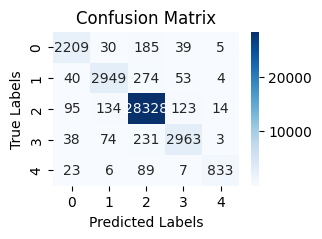

In [20]:
evaluate(y_test, y_pred)